In [1]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.stats import lognorm
import math
from datetime import date
import seaborn as sns
import pandas as pd

In [2]:
def histogram(a,values):
    xmin=np.min(a)
    xmax=np.max(a)
    L=100 #the number of segments
    Del=(xmax-xmin)/L
    bin_cents=[xmin+Del/2+k*Del for k in range(L)]
    bin_mins=[xmin+k*Del for k in range(L)]
    bin_maxs=[xmin+(k+1)*Del for k in range(L)]
    counts=np.zeros(L)
    for c1 in range(values):
        k=int(np.floor((a[c1]-xmin)/Del))
        if k>=L:
            counts[L-1]+=1
        else:
            counts[k]+=1
    sns.set_style('whitegrid')
    axes=sns.barplot(x=bin_cents,y=counts/values,palette='bright')
    axes.set(xlabel='Value',ylabel='Frequency')

In [3]:
class Options:
    def __init__(self, symbol, start_date, end_date = date.today()):
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        self.hist = yf.download(symbol, start=start_date, end=end_date) #Download history for the given symbol
        self.contractData = yf.Ticker(symbol)
        self.returns = (self.hist["Adj Close"] / self.hist["Adj Close"].shift(1)).dropna()
        self.mu = self.returns.mean()
        self.sigma = self.returns.std()
        self.DF_calls, self.DF_puts = self.contractData.option_chain(self.contractData.options[0])
        self.S0 = self.hist["Adj Close"][-1] # current stock price
        self.r = 0.05 # risk-free rate
        self.T = 1/365 # time to maturity
        self.M = 500 # number of time steps
        self.N = 1000 # number of simulations
        self.q = 0.03 # annual dividend rate
        self.priceMatrix = np.zeros((self.N, self.M+1))
        
        
    def monteCarlo(self):
        dt = self.T / self.M
        self.priceMatrix[:, 0] = self.S0
        for i in range(self.N):
            for j in range(1, self.M+1):
                self.priceMatrix[i, j] = self.priceMatrix[i, j-1] * np.exp((self.mu - 0.5 * self.sigma**2) * dt + self.sigma * np.sqrt(dt) * np.random.normal())
        
    def plotMonteCarlo(self):
        fig, ax = plt.subplots()
        ax.plot(self.priceMatrix.T)
        ax.set_xlabel("Time")
        ax.set_ylabel("Stock Price")
        ax.set_title("Simulated Stock Price")
        plt.show() 
        
    def plotHistStock(self):
        fig, ax = plt.subplots()
        ax.plot(self.hist["Adj Close"])
        ax.set_xlabel("Date")
        ax.set_ylabel("Stock Price")
        plt.show()
        
    def plotSimulationStock(self):
        histogram((self.priceMatrix.T)[self.M-1,:],self.N)
        
    
    def plotIdeal(self):
        print(self.S0)
        mu = self.S0*math.exp((self.r + self.sigma**2 / 2)*self.T)
        print(mu)
        #print(np.mean(self.priceMatrix[:, -1]))
        sigma2 = self.S0**2 * math.exp(self.r*self.T)**2 * (math.exp(self.sigma**2 * self.T - 1))
        print(sigma2)
        #print((self.priceMatrix.T)[self.M-1,:].std()**2)
        deviations = self.priceMatrix[:, -1] - np.mean(self.priceMatrix[:, -1])
        squared_deviations = deviations**2
        mean_squared_deviation = np.mean(squared_deviations)
        print(mean_squared_deviation)
        s = np.sqrt((self.priceMatrix.T)[self.M-1,:].std())
        scale = np.exp(mu)
        x = np.linspace(0, 10, 100)
        pdf = lognorm.pdf(x, s=s, scale=scale)
        plt.plot(x, pdf)
        plt.title('Lognormal Distribution with mu = {} and sigma^2 = {}'.format(mu, s))
        plt.xlabel('X')
        plt.ylabel('PDF')
        plt.show()
        
    def blackScholesCall(self,K,T):
        d1 = (np.log(self.S0/K) + (self.r - self.q + self.sigma**2/2)*T) / self.sigma*np.sqrt(T)
        d2 = d1 - self.sigma* np.sqrt(T)
        call = self.S0 * np.exp(-self.q*T)* norm.cdf(d1) - K * np.exp(-self.r*T)*norm.cdf(d2)
        return call
    
    def simulationCall(self,K,T):
        payoffs = np.maximum(self.priceMatrix[-1]-K, 0)
        option_price = np.mean(payoffs)*np.exp(-self.r*T) #discounting back to present value
        return option_price
    
    def simulationPut(self,K,T):
        payoffs = np.maximum(K-self.priceMatrix[-1],0)
        options_price=np.mean(payoffs)*np.exp(-self.r*T)
        return options_price

    def avg(self):                                          #averaging function
        iter=self.priceMatrix.shape[0]
        len=self.priceMatrix.shape[1]
        avgList=np.zeros(iter)
        sum=0
        for i in range(iter):
            for j in range(len):
                sum=sum+self.priceMatrix[i][j]
            avgList[i]=sum/len
            sum=0
        return avgList
            
    def blackScholesPut(self,K,T):                          #Black Scholes Put
        d1 = (np.log(self.S0/K) + (self.r - self.q + self.sigma**2/2)*T) / self.sigma*np.sqrt(T)
        d2 = d1 - self.sigma* np.sqrt(T)
        put =  K * np.exp(-self.r*T)*norm.cdf(-d2) - self.S0 * np.exp(-self.q*T)* norm.cdf(-d1)
        return put
        


[*********************100%***********************]  1 of 1 completed


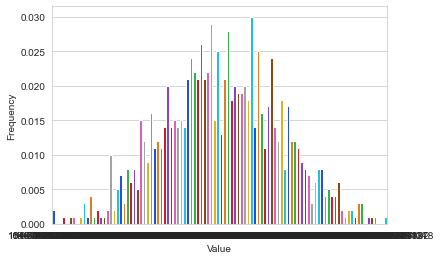

In [4]:
TSLA = Options("JNJ", "2019-04-08")
TSLA.monteCarlo()
TSLA.plotSimulationStock()
# print(TSLA.priceMatrix,"\n")
# print(TSLA.priceMatrix.T)
# print(TSLA.priceMatrix.shape[0])

165.02999877929688
165.05264580231793
10021.910017251126
0.013224804499538065


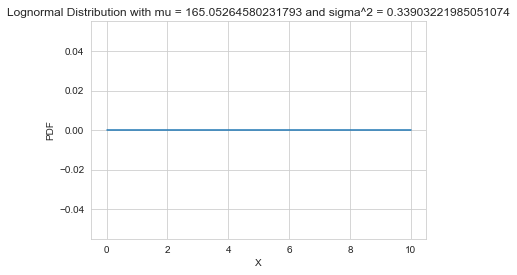

In [5]:
TSLA.plotIdeal()

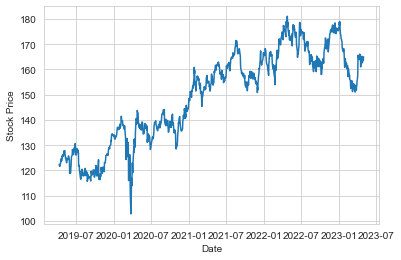

In [6]:
TSLA.plotHistStock()

Text(0, 0.5, 'Average')

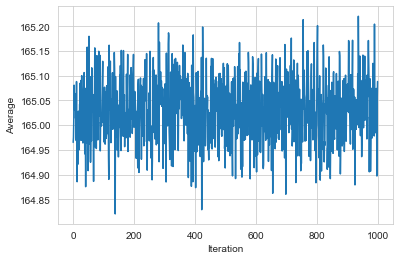

In [7]:
plt.plot(TSLA.avg())
plt.xlabel("Iteration")
plt.ylabel("Average")

In [8]:

#testing data
print(TSLA.blackScholesPut(164.92,TSLA.T))
print(TSLA.simulationPut(164.92,TSLA.T))



-0.014370276826497275
0.0


[-2.8598276  -5.91969197 -6.29672166 -6.37063821 -6.35259722 -6.31889317
 -6.26904192 -6.20258569 -6.11909391 -6.0181639  -5.43301358 -5.23986267
 -4.67236841 -3.98193552 -3.16695019 -2.22688578 -1.16224299  0.02552373
  1.33409022  2.76035405  4.30053054  5.95025077] 



[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 2.41131719 4.91097474 7.4106323  9.91028986] 





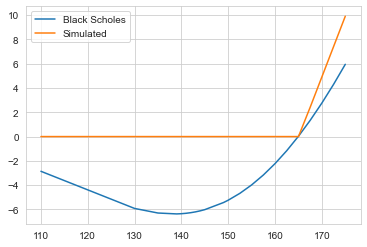

In [9]:
strikePrice=TSLA.DF_puts.strike
l=len(strikePrice)
blkschPut=np.zeros(l)
simPut=np.zeros(l)

for i in range(l):
    blkschPut[i]=TSLA.blackScholesPut(strikePrice[i],TSLA.T)
    simPut[i]=TSLA.simulationPut(strikePrice[i],TSLA.T)

print(blkschPut,"\n\n\n")
print(simPut,"\n\n\n")

plt.plot(strikePrice,blkschPut,label="Black Scholes")
plt.plot(strikePrice,simPut,label="Simulated")

plt.legend()
